# Time Series

Forecasting plays a vital role in various domains by enabling organizations to make informed decisions based on future predictions. Time series forecasting, in particular, focuses on analyzing and predicting data points that are collected over a sequence of time intervals. Time series data is abundant in many fields, such as finance, economics, sales, weather, and more. Its importance lies in the ability to identify patterns, trends, and seasonality within the data to generate accurate predictions. To facilitate the forecasting process, tools like Facebook Prophet have gained popularity. Facebook Prophet is a powerful and user-friendly library specifically designed for time series forecasting, offering a simplified approach to generating accurate predictions. Evaluation metrics like R-squared (R2) and Root Mean Squared Error (RMSE) are widely used to assess the performance of forecasting models. R2 measures the proportion of the variance in the target variable explained by the model, while RMSE quantifies the average difference between predicted and actual values. These metrics provide valuable insights into the accuracy and quality of the forecasts, assisting decision-makers in evaluating and comparing different forecasting models.


# Introduction

The company Sweet Lift Taxi has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the number of taxi orders for the next hour. Let's build a model for such prediction.


## Objective

1. Download the data and resample it to one hour intervals.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset.
4. Test the data using the test sample and provide a conclusion.

## Data Description

The data is stored in the file 'taxi.csv'.
The number of orders is in the column 'num_orders'.

## Set Up

In [27]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from prophet import Prophet

In [2]:
df = pd.read_csv('taxi.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [3]:
df.duplicated().sum()

0

We did not find any missing values or duplicate values.

We print the first few rows of the 'df' table:

In [4]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


We have encountered a time series case, where we have a column 'datetime' that is currently of type 'object'. We need to convert the data to a suitable format, select the period for analysis, and plot the time series graph.

- Let's change the data type of the 'datetime' data from 'object' to 'datetime64'.
- Let's set the index of the table to be equal to the 'datetime' column.
- Let's sort the index of the table and check if the dates and times are in chronological order.


In [5]:
df = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])
df.sort_index(inplace=True)
print(df.index.is_monotonic_increasing)
print(df.info())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


## Analysis

Since the dates and times are in chronological order, we can conclude that we have data from the period of March 2018 to August 2018. Let's select a smaller period of data for easier analysis. From the time series, let's choose data from August 2018.


In [6]:
data = df['2018-08':'2018-08']
print(data.info())
data.head(7)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4464 entries, 2018-08-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4464 non-null   int64
dtypes: int64(1)
memory usage: 69.8 KB
None


,num_orders
datetime,
2018-08-01 00:00:00,38
2018-08-01 00:10:00,27
2018-08-01 00:20:00,23
2018-08-01 00:30:00,25
2018-08-01 00:40:00,40
2018-08-01 00:50:00,29
2018-08-01 01:00:00,27


<Axes: xlabel='datetime'>

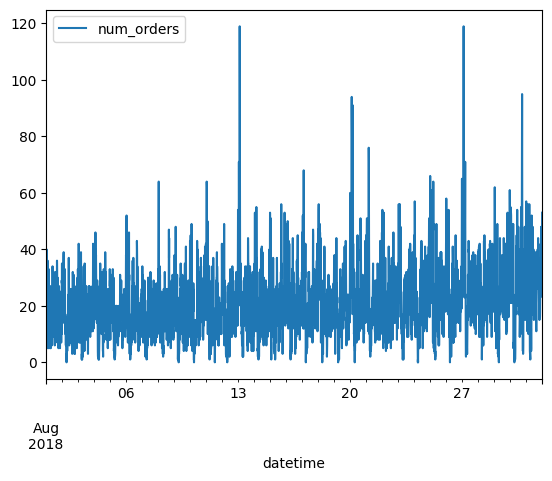

In [7]:
data.plot()

This time series has intervals of 10 minutes, which we need to correct. Additionally, the graph does not provide much insight, so we should explore other analysis techniques.

We can use **resampling** since we have values from March to August 2018. Let's examine the total number of orders per month:


            num_orders
datetime              
2018-03-31       42768
2018-04-30       45939
2018-05-31       54820
2018-06-30       59906
2018-07-31       74405
2018-08-31       94973


<Axes: title={'center': 'Monthly Orders'}, xlabel='datetime'>

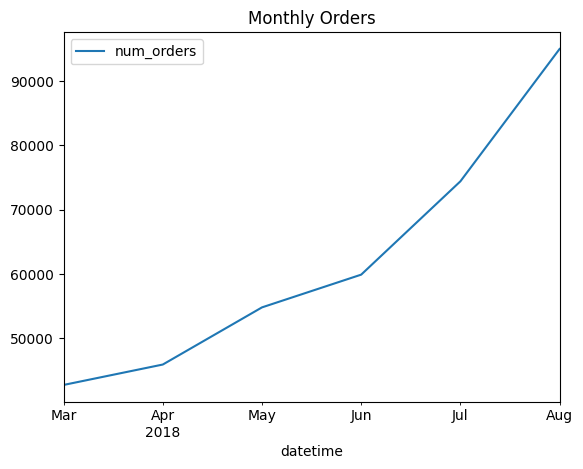

In [8]:
total_monthly_orders = df.resample('1M').sum()
print(total_monthly_orders)
total_monthly_orders.plot(title='Monthly Orders')

We observe the increasing trend in the number of orders per month. Now, let's examine the total number of orders per hour but only for the last 15 days of the month of August, which is available in our variable 'data':


                     num_orders
datetime                       
2018-08-15 00:00:00         211
2018-08-15 01:00:00          98
2018-08-15 02:00:00         157
2018-08-15 03:00:00         102
2018-08-15 04:00:00         137
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[408 rows x 1 columns]


<Axes: title={'center': 'Número de pedidos por hora en agosto'}, xlabel='datetime'>

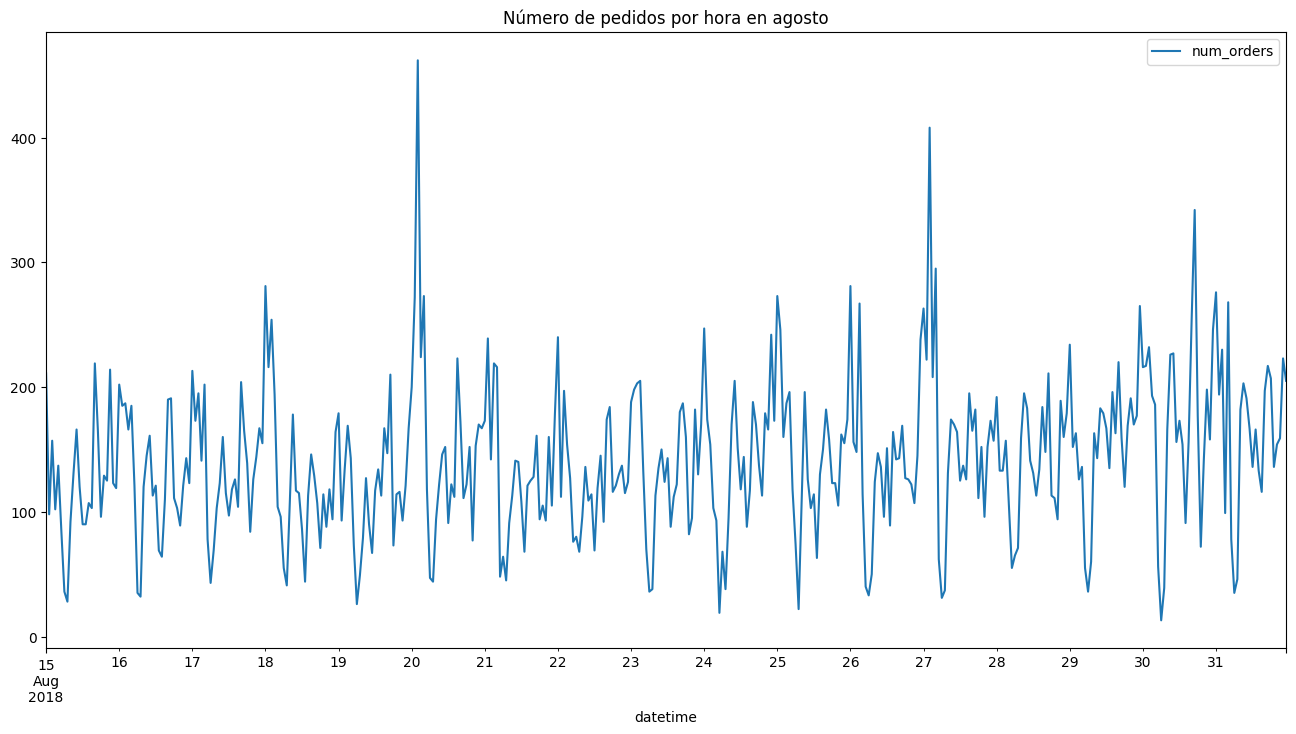

In [9]:
data = data['2018-08-15':'2018-08-31']
total_hour_orders = data.resample('1H').sum()
print(total_hour_orders)
total_hour_orders.plot(figsize=(16, 8), title='Número de pedidos por hora en agosto')

While it is true that we can observe the fluctuations in the number of orders per hour for the month of August a little better, it remains difficult to estimate the number of orders. It is better to continue searching for new tools to analyze the series.

To better understand the time series, let's analyze the trends and seasonality, and using the moving average, we can reduce the fluctuations in a time series

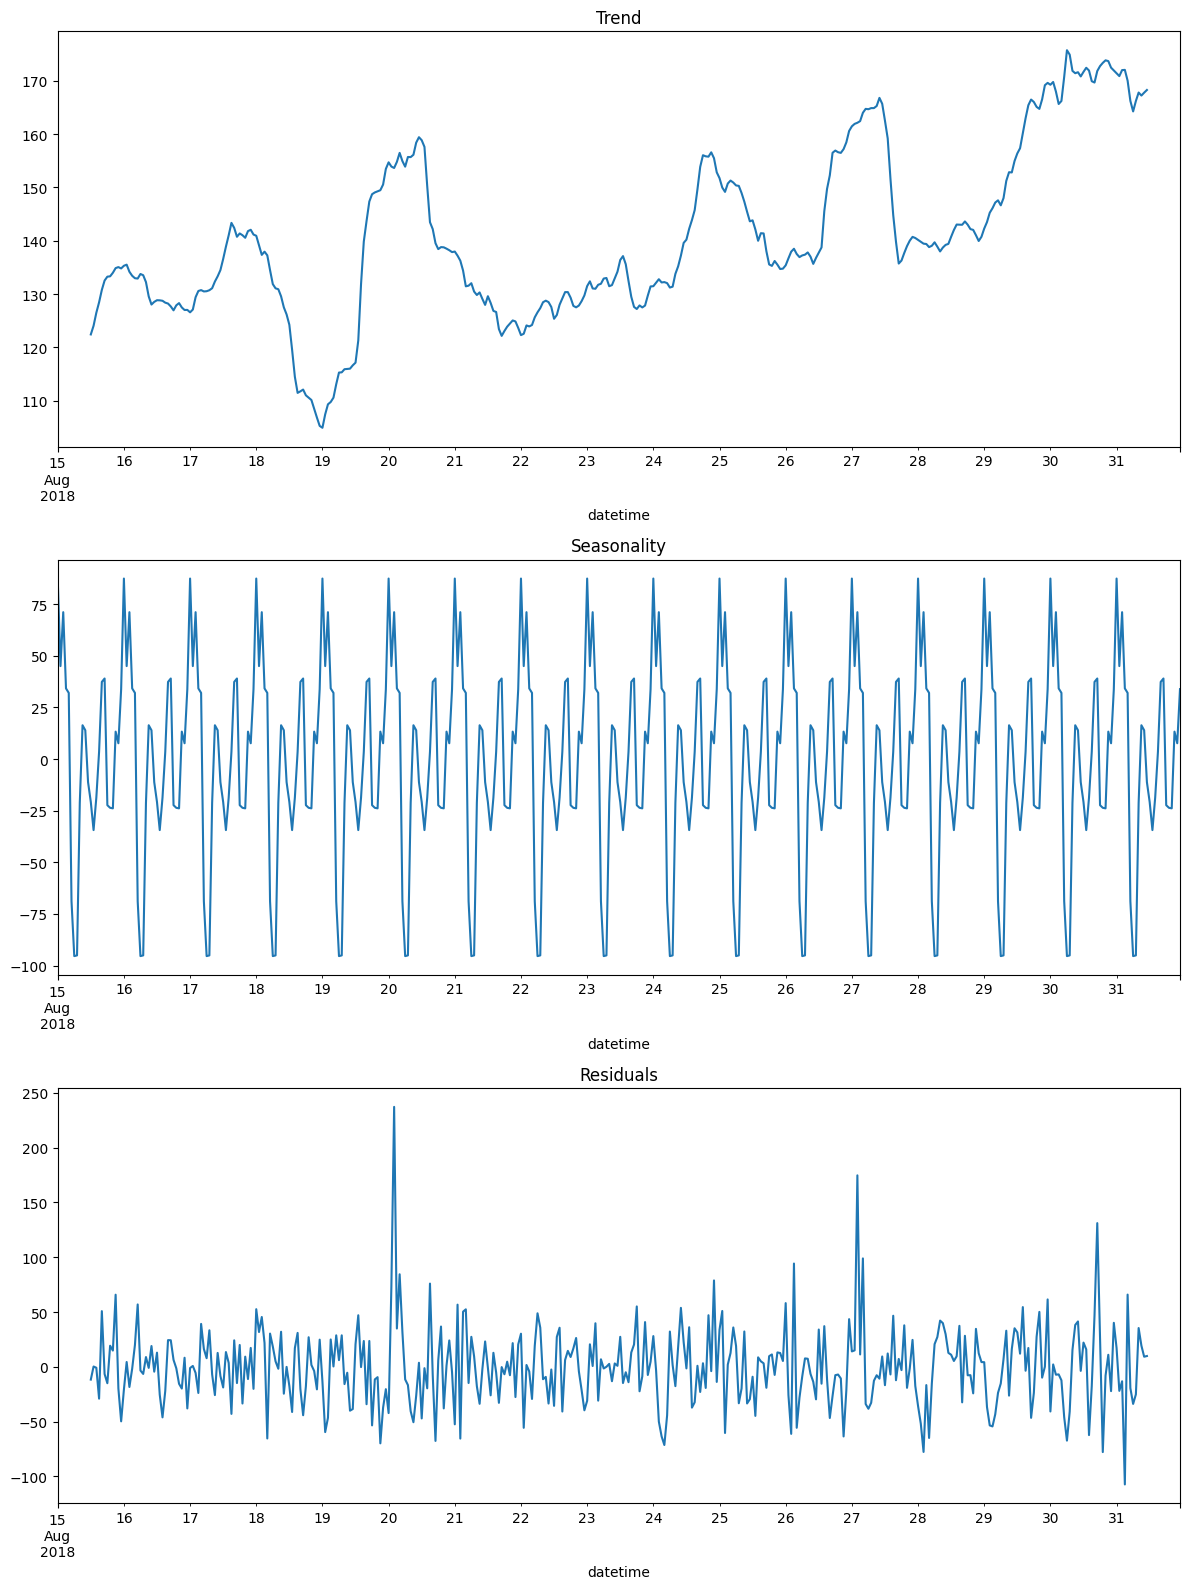

In [10]:
decomposed = seasonal_decompose(total_hour_orders)

plt.figure(figsize=(12, 16))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

When decomposing a time series, you can identify patterns and key components that make it up.

The **trend** shows the general direction of the data in the long term, which is important to identify if there is any upward or downward trend in the values over time. This can help you better understand the underlying behavior of the series and detect possible changes or fluctuations.

**Seasonality** indicates repetitive and predictable patterns that occur within a shorter time interval, such as daily, weekly, or yearly seasonality. Identifying and understanding these seasonal patterns is crucial for properly adjusting and predicting the data.

The **residuals** represent the part not explained by the trend and seasonality. By analyzing the residuals, you can identify patterns not captured by the other components and assess if there is any random behavior or noise in the data.

By visualizing each component separately, you can gain a clearer understanding of how the data is decomposed and how each of these components influences the original time series.


When decomposing a time series into trend, seasonality, and residuals, it's important to ensure that the decomposition accurately captures the underlying patterns and fluctuations in the original data. By comparing the sum of the decomposed components with the original data, we can verify that the decomposition is capturing the complete information from the original series.

If the sum of the decomposed components matches the original data, it indicates that the decomposition has successfully separated the time series into its key components without any loss or distortion of information. This confirms the accuracy of the decomposition and gives you confidence in the individual components representing the various patterns and variations in the data.

In [11]:
print(decomposed.trend[20:22] + decomposed.seasonal[20:22] + decomposed.resid[20:22])
print()
print(total_hour_orders[20:22]) 

datetime
2018-08-15 20:00:00    125.0
2018-08-15 21:00:00    214.0
Freq: H, dtype: float64

                     num_orders
datetime                       
2018-08-15 20:00:00         125
2018-08-15 21:00:00         214


**Question 1: What does the trend component of a decomposed time series represent?**

- a) Short-term fluctuations
- b) Repetitive and predictable patterns
- c) General direction in the long term
- d) Random behavior or noise

**Question 2: Why is it important to identify and understand seasonal patterns in a time series?**

- a) To assess short-term fluctuations
- b) To detect possible changes or fluctuations
- c) To adjust the data for outliers
- d) To properly predict and forecast the data

**Question 3: What information can be derived from analyzing the residuals of a decomposed time series?**

- a) Repetitive and predictable patterns
- b) General direction in the long term
- c) Random behavior or noise
- d) Short-term fluctuations


<details>
<summary>
Answers: </summary>
c) General direction in the long term
d) To properly predict and forecast the data
c) Random behavior or noise
</details>

# Moving Average, Rolling Mean

A rolling mean, also known as a moving average, is a statistical calculation that smooths out fluctuations or noise in a time series data by calculating the average of a specified window or interval of consecutive data points.

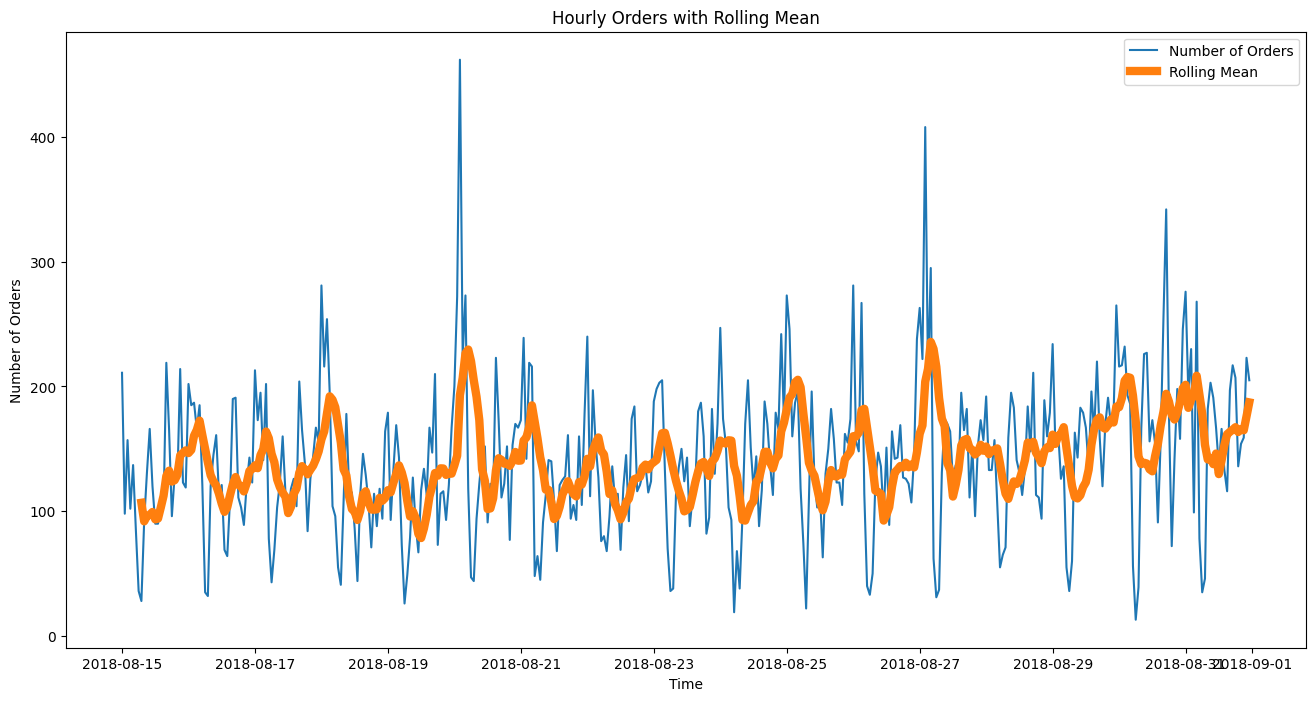

In [12]:
# Calculate the rolling mean with a window of 8
total_hour_orders['rolling_mean'] = total_hour_orders['num_orders'].rolling(8).mean()

# Plot the data
plt.figure(figsize=(16, 8))
plt.plot(total_hour_orders.index, total_hour_orders['num_orders'], label='Number of Orders')
plt.plot(total_hour_orders.index, total_hour_orders['rolling_mean'], linewidth=6, label='Rolling Mean')
plt.xlabel('Time')
plt.ylabel('Number of Orders')
plt.title('Hourly Orders with Rolling Mean')
plt.legend()
plt.show()


It appears that the trends are related to the time of day, with a high number of orders at the beginning of the day. The seasonality has a period of one day, and the residuals do not have a clear explanation.

Upon reviewing the moving average, we can see that a pattern repeats for each day. At the early hours of the day, there is an increase in the number of orders, which gradually decreases as the hours pass until the end of the day.

Let's take a look at a graph for the seasonal component of the last week of August:


<Axes: xlabel='datetime'>

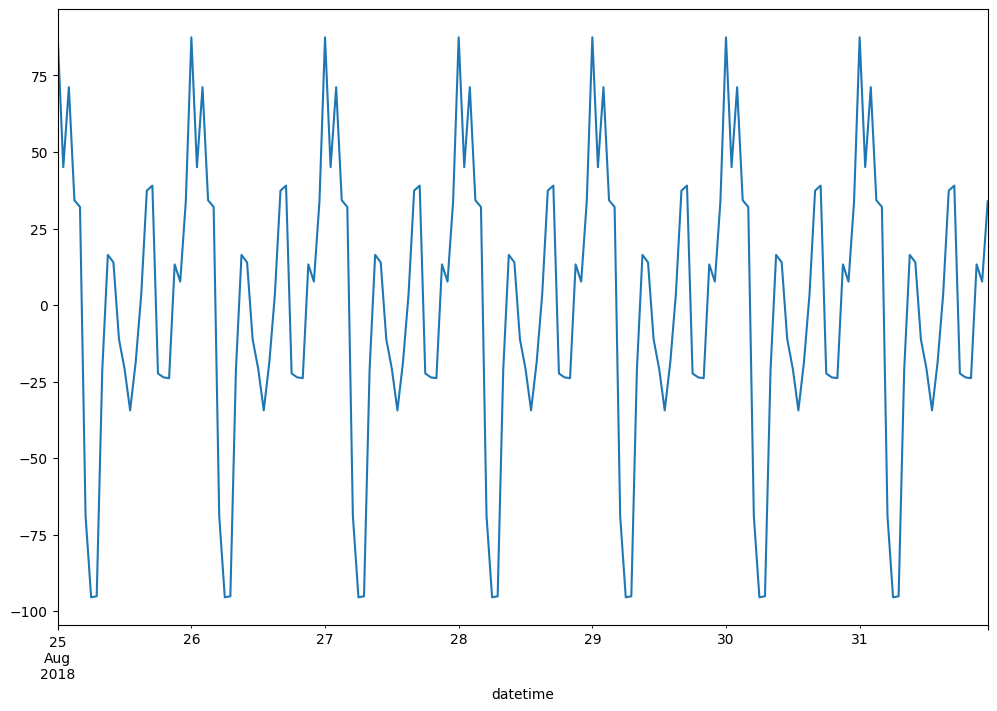

In [13]:
decomposed.seasonal['2018-08-25':'2018-08-31'].plot(figsize=(12, 8))

As we can observe, the number of orders tends to be lower after the early hours of the day.

Now let's review the differences of time series. To make a series stationary, we can take the differences between its values.

<Axes: xlabel='datetime'>

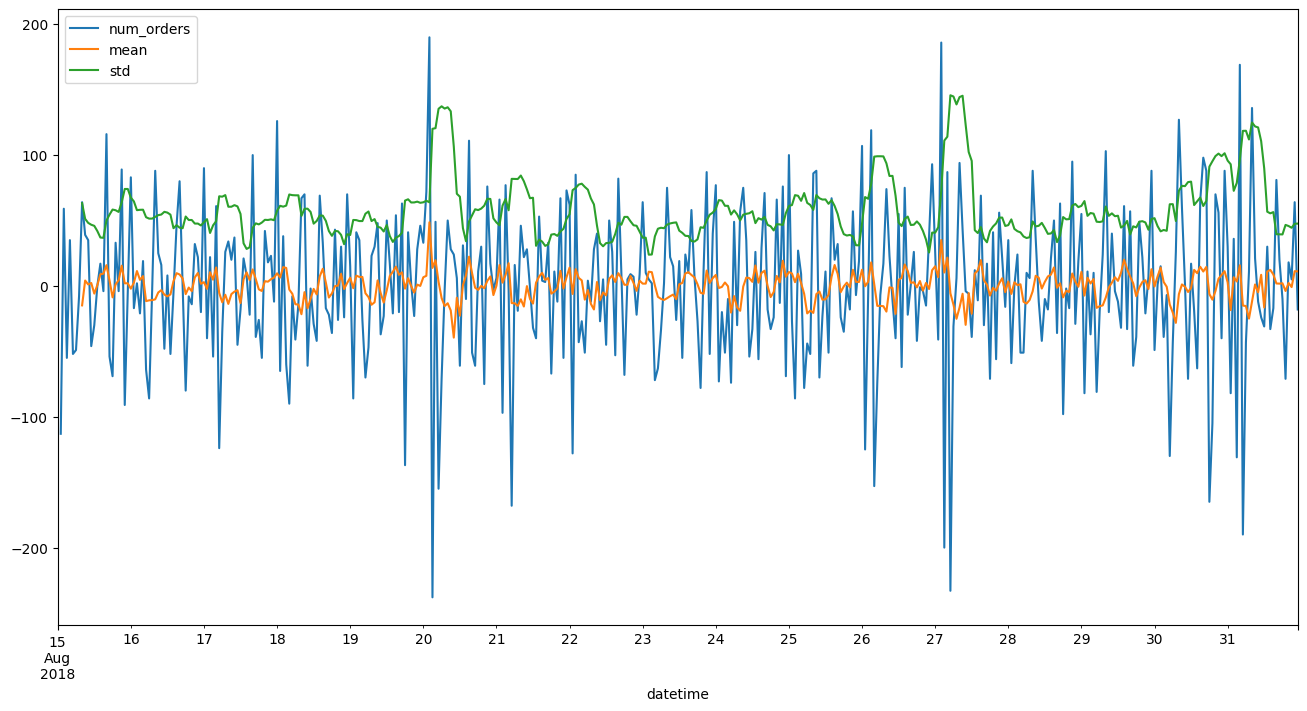

In [14]:
data_diff = df['2018-08-15':'2018-08-31'].resample('1H').sum()
data_diff -= data_diff.shift()
data_diff['mean'] = data_diff['num_orders'].rolling(8).mean()
data_diff['std'] = data_diff['num_orders'].rolling(8).std()
data_diff.plot(figsize=(16, 8))

The differences, rolling mean, and rolling standard deviation are techniques used in time series analysis to make the data more stationary.

**Differences**: Taking differences involves calculating the changes between consecutive observations in a time series. By subtracting each data point from its previous data point, you obtain a new series that represents the changes or fluctuations over time. This technique helps remove the trend component from the data, making it more stationary.

**Rolling Mean**: The rolling mean (also known as the moving average) is a statistical calculation that smooths out fluctuations in a time series by calculating the average of a specified window or interval of consecutive data points. It provides an estimate of the underlying trend or long-term pattern in the data. By calculating the rolling mean, you can reduce short-term fluctuations and highlight the overall trend, making the data more stationary.

**Rolling Standard Deviation**: The rolling standard deviation measures the variability or dispersion of a time series within a given window or interval. It quantifies how the data points deviate from the rolling mean. By calculating the rolling standard deviation, you can assess the volatility or fluctuations around the trend component. It helps in understanding the overall variability in the data and can be useful for identifying periods of high or low volatility.

**The goal of these techniques is to make the data stationary**. Stationarity is an important assumption in many time series models as it ensures that the statistical properties of the data remain constant over time. Stationary data typically exhibits a constant mean, constant variance, and autocovariance that depends only on the time lag.

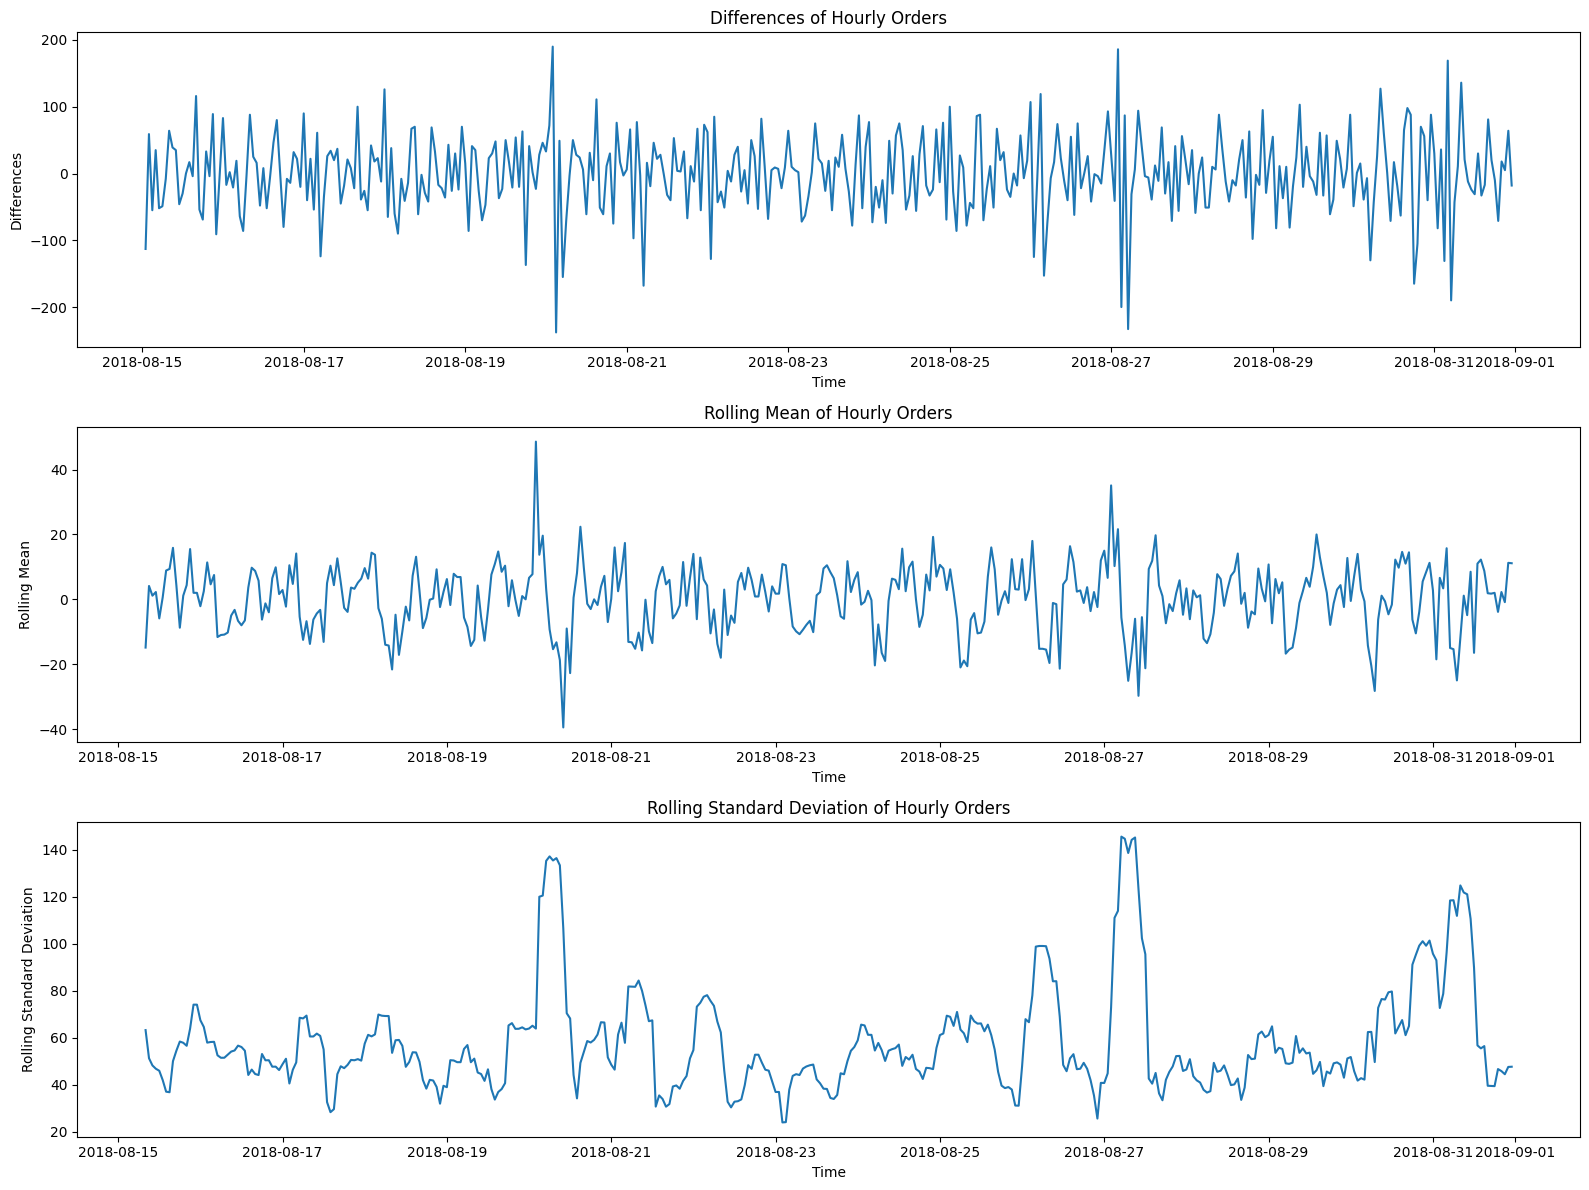

In [25]:
# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(16, 12))

# Plot the differences
axs[0].plot(data_diff.index, data_diff['num_orders'])
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Differences')
axs[0].set_title('Differences of Hourly Orders')

# Plot the rolling mean
axs[1].plot(data_diff.index, data_diff['mean'])
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Rolling Mean')
axs[1].set_title('Rolling Mean of Hourly Orders')

# Plot the rolling standard deviation
axs[2].plot(data_diff.index, data_diff['std'])
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Rolling Standard Deviation')
axs[2].set_title('Rolling Standard Deviation of Hourly Orders')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


**Random Funny Fact:** Did you know that "stressed" spelled backward is "desserts"? So, whenever you're feeling stressed, just have some desserts and enjoy the sweet relief!

![Funny Giphy](https://media.giphy.com/media/JIX9t2j0ZTN9S/giphy.gif)


## Train Test Split

Let's divide the order number dataset into training and test sets in a 9:1 ratio. We'll use the data for the available period, but first, let's resample it into a validation variable df_val before using our main variable df.

Let's check the minimum and maximum index values of both sets to ensure that the division is done correctly.


In [15]:
df_val = df.resample('1H').sum()
df_val.index = pd.to_datetime(df_val.index)
#To ensure that the data can be properly split, we should set shuffle = False 
# when dividing the dataset into training and test sets. 
# This will prevent any random shuffling of the data points.
train_val, test_val = train_test_split(df_val, shuffle=False, test_size=0.10)

print(train_val.index.min(), train_val.index.max())
print(test_val.index.min(), test_val.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


**Question: What is the purpose of performing a train-test split in machine learning?**

- a) To separate the dataset into two subsets: one for training the model and one for testing its performance.
- b) To randomly shuffle the data to ensure unbiased representation in both training and testing sets.
- c) To determine the optimal hyperparameters for the model.
- d) To evaluate the model's performance on unseen data and assess its generalization ability.



<details>
<summary>
Answers: </summary>
a) To separate the dataset into two subsets: one for training the model and one for testing its performance.
</details>

In [16]:
train_val.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


The training set ends on August 13th at 1:00 PM, and the test set starts on August 13th at 2:00 PM.

There are two ways to forecast time series without training and perform sanity checks on the model:
- All values in the test sample are forecasted with a constant.
- Predict using the previous value of the series.

In [17]:
print('Average number of orders:', test_val['num_orders'].median())
pred_median = np.ones(test_val.shape) * train_val['num_orders'].median()
print('RMSE:', mean_squared_error(test_val, pred_median) ** 0.5) 
# ** 0.5 is used to calculate the square root of the mean squared error (MSE).


Average number of orders: 135.0
RMSE: 87.15277582981295


"RECM" stands for Root Mean Squared Error (RMSE). It is a commonly used metric to measure the average difference between the predicted values and the actual values in a regression or forecasting problem.

In [18]:
print('Average number of orders:', test_val['num_orders'].median())
pred_previous = test_val.shift()
pred_previous.iloc[0] = train_val.iloc[-1]
print('RMSE:', mean_squared_error(test_val, pred_previous) ** 0.5)
# ** 0.5 is used to calculate the square root of the mean squared error (MSE).


Average number of orders: 135.0
RMSE: 58.856486242815066


In [21]:
# Prepare the data for Prophet
df = df_val.reset_index().rename(columns={'datetime': 'ds', 'num_orders': 'y'})

# Create a Prophet model
model = Prophet()

# Fit the model to the data
model.fit(df)

# Generate future dates for forecasting
future_dates = model.make_future_dataframe(periods=12, freq='M')

# Make predictions
forecast = model.predict(future_dates)

# Calculate evaluation metrics
actual_values = df['y'].values
predicted_values = forecast['yhat'].values[:-12]  # Exclude the future predictions
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
r2 = r2_score(actual_values, predicted_values)

# Print the evaluation metrics
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared (R2):', r2)


23:56:09 - cmdstanpy - INFO - Chain [1] start processing
23:56:09 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error (RMSE): 27.111468440627313
R-squared (R2): 0.6373237513224036


The Root Mean Squared Error (RMSE) is a commonly used metric to evaluate the accuracy of a forecasting model. In this case, the RMSE value of 27.11 indicates the average difference between the predicted values and the actual values of the target variable (number of orders) is approximately 27.11 units. A lower RMSE value suggests that the model has a smaller average prediction error and is considered better in terms of accuracy.

The R-squared (R2) is a statistical measure that represents the proportion of the variance in the target variable that can be explained by the model. In this case, an R2 value of 0.64 suggests that the model is able to explain approximately 63.73% of the variance in the number of orders. A higher R2 value indicates that the model fits the data well and can account for a larger proportion of the variability.

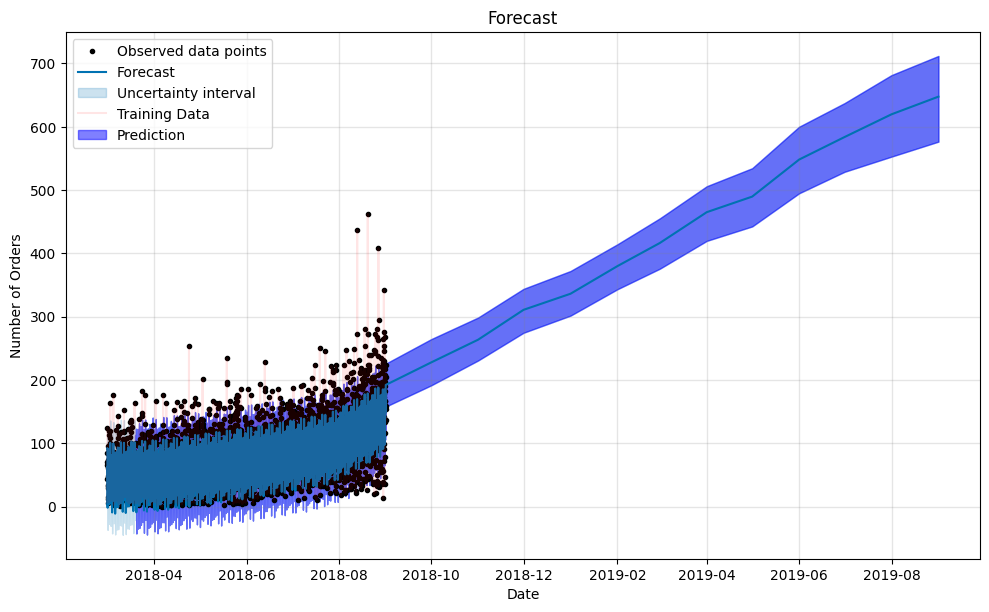

In [22]:
# Extract training data
train_data = df.copy()

# Plot the forecast
fig, ax = plt.subplots(figsize=(10, 6))
model.plot(forecast, ax=ax)

# Color the training data in red
ax.plot(train_data['ds'], train_data['y'], alpha=0.1, color='red', label='Training Data')

# Color a fraction of the prediction data in blue
fraction = 0.9  # Specify the fraction of the prediction to color
num_points = len(forecast)
start_index = int(num_points * (1 - fraction))

ax.fill_between(forecast['ds'].iloc[start_index:], forecast['yhat_lower'].iloc[start_index:],
                forecast['yhat_upper'].iloc[start_index:], color='blue', alpha=0.5, label='Prediction')

# Set plot labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Number of Orders')
ax.set_title('Forecast')

# Add legend
ax.legend()

# Show the plot
plt.show()


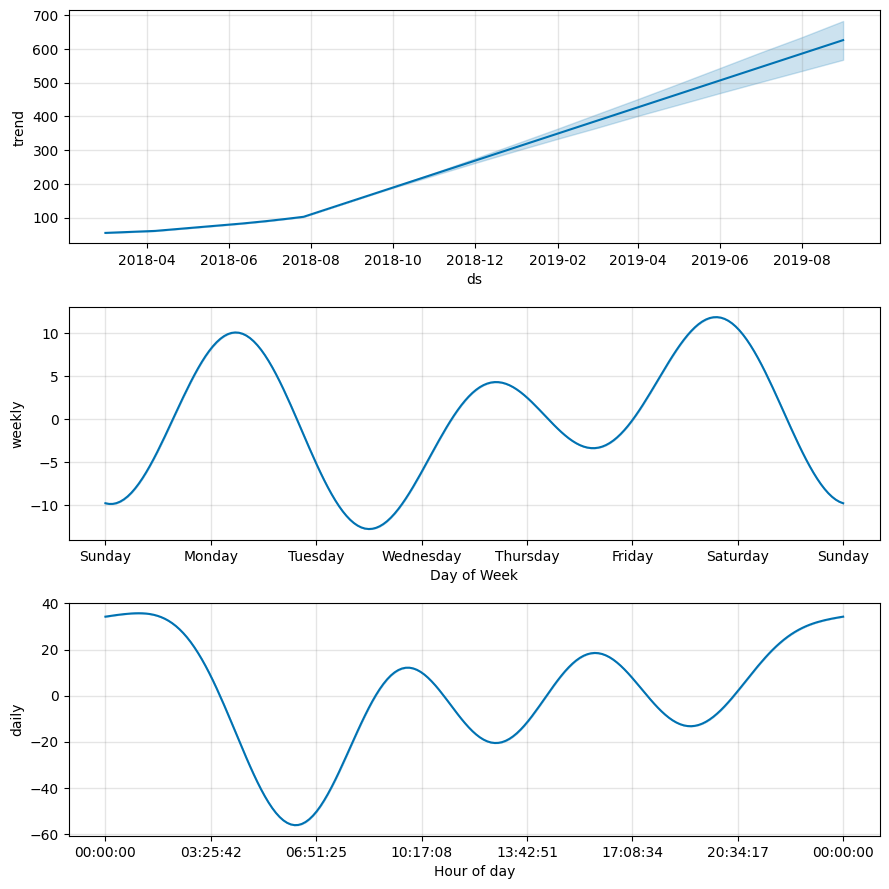

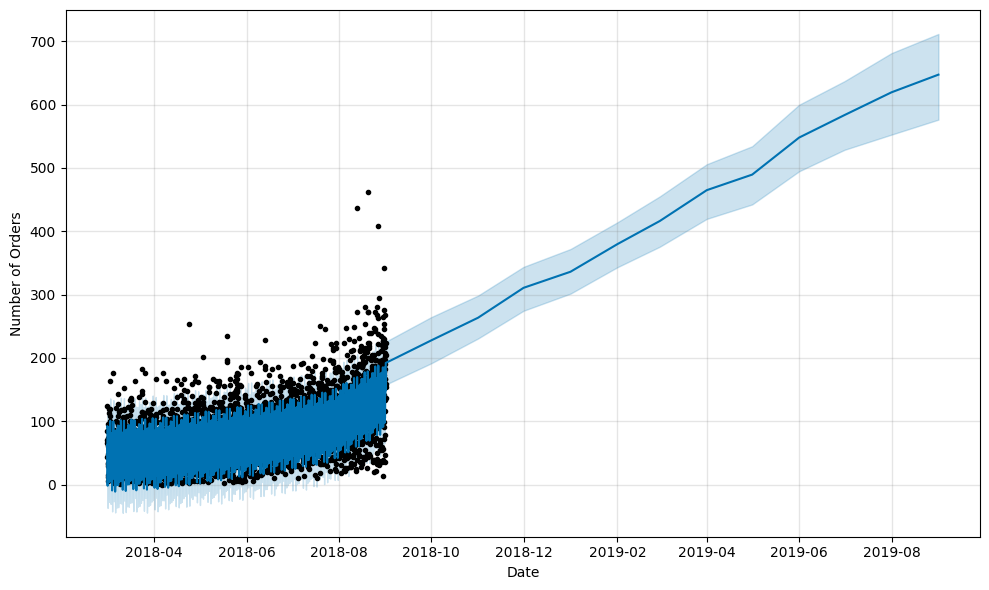

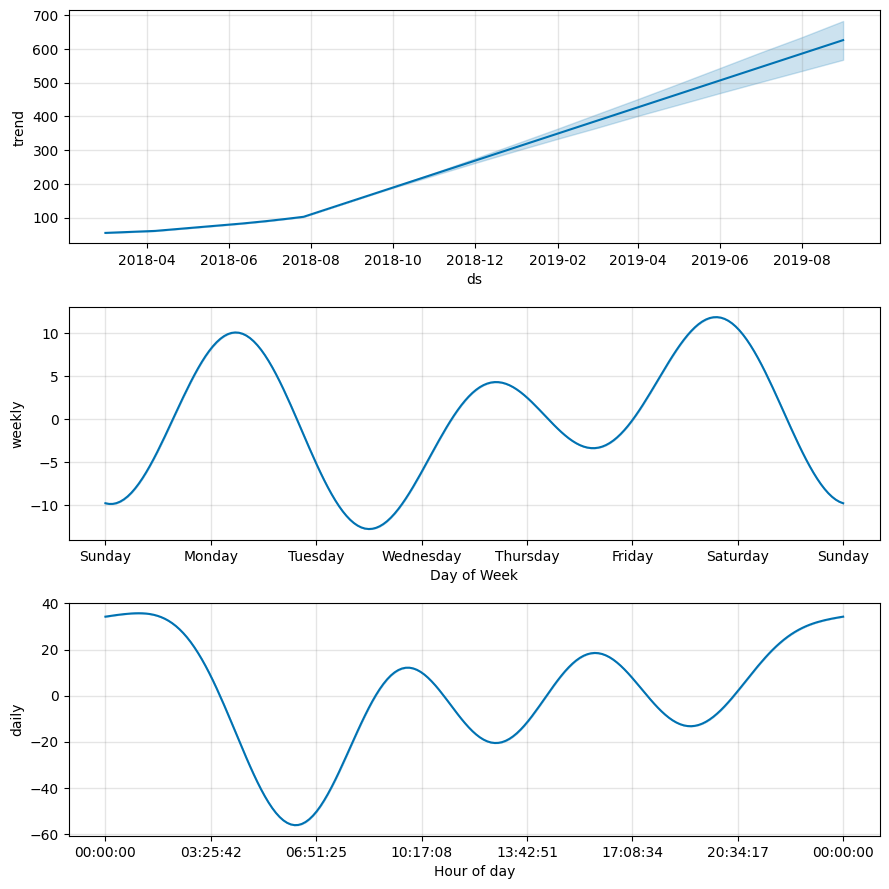

In [23]:
# Plot the forecast
model.plot(forecast, xlabel='Date', ylabel='Number of Orders')

# Show the forecast components
model.plot_components(forecast)

The forecasting methodology of Prophet is based on a generalized additive model (GAM) framework, which combines the trend, seasonality, and holiday components in an additive manner. The model fits the data using a Bayesian framework and employs a technique called Markov Chain Monte Carlo (MCMC) to obtain uncertainty intervals for the forecasts.